# Neural posterior estimation

This tutorial demonstrates how to perform neural posterior estimation (NPE) with LAMPE.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import zuko

from itertools import islice
from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import corner, mark_point, nice_rc
from lampe.utils import GDStep
from tqdm import trange

## Simulator

In [3]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([-0.8004, -0.1925,  0.1609])
tensor([-0.8537,  0.3386])


In [4]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

Similar to PyTorch, [`lampe`](lampe) provides building blocks that have to be assembled by the user to perform inference. In the case of neural posterior estimation (NPE), we train a conditional normalizing flow $p_\phi(\theta | x)$ to approximate the posterior distribution $p(\theta | x)$. The [`lampe.inference`](lampe.inference) module provides the [`NPE`](lampe.inference.npe.NPE) class to create a normalizing flow adapted to the simulator's input and output sizes. By default, the normalizing flow is a masked autoregressive flow (MAF) with affine transforms borrowed from the [`zuko`](zuko) package.

In [5]:
estimator = NPE(3, 2, transforms=3, hidden_features=[64] * 3)
estimator

NPE(
  (flow): MAF(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [0, 1, 2]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): MaskedLinear(in_features=64, out_features=6, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [2, 1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
         

In the case of NPE, the loss to minimize is the expected negative log-likelihood of the data $ \mathbb{E}_{p(\theta, x)} \big[ -\log p_\phi(\theta | x) \big] $, which is easy to implement ourselves.

In [6]:
def nll(theta, x):
    log_p = estimator(theta, x)  # log p(theta | x)
    return -log_p.mean()

For other algorithms, it might not be as straightforward to implement the loss. Conveniently, the [`lampe.inference`](lampe.inference) module provides the losses of the algorithms it implements, in this case [`NPELoss`](lampe.inference.npe.NPELoss).

In [7]:
loss = NPELoss(estimator)

We implement the training routine as a series of stochastic gradient descent (SGD) epochs over the training set. Because LAMPE is based on PyTorch, any PyTorch optimizer can be used (e.g. [SGD](torch.optim.SGD), [Adam](torch.optim.Adam), ...) and features such as gradient clipping can be easily implemented.

In [8]:
optimizer = optim.Adam(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

for epoch in (bar := trange(64, unit='epoch')):
    losses = []

    for theta, x in islice(loader, 256):  # 256 batches per epoch
        losses.append(step(loss(theta, x)))

    bar.set_postfix(loss=torch.stack(losses).mean().item())

100%|██████████| 64/64 [00:29<00:00,  2.14epoch/s, loss=-2.48]


## Inference

Now that the posterior estimator is trained, we can use it to perform inference. For instance, we can inspect the posterior of any observation $x^*$. Since normalizing flows are proper distributions, we can sample directly from $p_\phi(\theta | x^*)$ and visualize the distribution with the [`corner`](lampe.plots.corner) function provided by the [`lampe.plots`](lampe.plots) module. 

In [9]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    samples = estimator.flow(x_star).sample((2**16,))

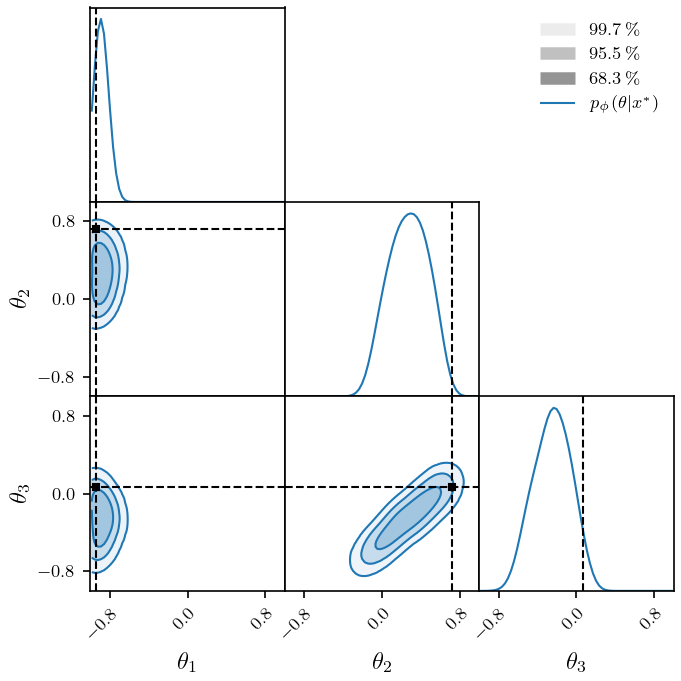

In [10]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)